In [3]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import pyarrow 
import pandas as pd
from matplotlib import pyplot as plt 


import json
import xtrack as xt
import xpart as xp
import xobjects as xo 
import numpy as np
from scipy.constants import c as speed_c
from scipy.constants import e as qe
from scipy.constants import m_p
from matplotlib import pyplot as plt 
import scipy as sp
import pandas as pd
import sys
import math
import json
import xdeps as xd
from xdeps.madxutils import MadxEval
import conda





In [56]:
# new implementation 



def centre_beam(x, px): # find the average of the beam and move it to 0,0
    x_centre = []
    px_centre = []
    
    
    x_avg = np.average(x)
    x_centre = x - x_avg

    px_avg = np.average(px)
    px_centre = px - px_avg

    return x_centre,px_centre 

def calculate_emittance(x,px): # assumes normalised coordinates 
    
    emittance=[]
      
    x_sq = np.multiply(x,x)
    xpx = x*px
    
    
    x_sq = np.multiply(x,x)
    px_sq = np.multiply(px,px)
    xsq_avg = np.mean(x_sq)
    pxsq_avg = np.mean(px_sq)
    mult_avg = np.mean(xpx)
    

    emittance = (np.sqrt((xsq_avg*pxsq_avg)-(mult_avg**2)))
    return emittance

def normalise_emittance(x,px,gamma): # assumes normalised coordinates 
    emit = calculate_emittance(x,px)
    norm_emit = emit * gamma * np.sqrt((gamma**2-1)/gamma**2)
    return norm_emit 



##############################################################
def SVD_AlphaBeta(x,px):
    '''Taken from https://arxiv.org/pdf/2006.10661.pdf '''
    
    U,s,V= np.linalg.svd([x,px])         #SVD
    
    N = np.dot(U,np.diag(s))
    theta = np.arctan(-N[0,1]/N[0,0])    #AngleofR(theta)
    co=np.cos(theta) ; si=np.sin(theta)
    
    R = [[co,si],[-si,co]]   
    X = np.dot(N,R)                      #Floquetupto1/det(USR)
    
    beta = np.abs(X[0,0]/X[1,1])
    alpha = X[1,0]/X[1,1]
    
    # dropped
    ex =s[0]*s[1]/(len(x)/2.)            #emit=det(S)/(n/2)
    
    return alpha,beta

##############################################################


##############################################################
def phys2norm(x,px,alpha=None,beta=None,SVD=False):
    
    if SVD:
        alpha,beta = SVD_AlphaBeta(x,px)
        
    #N0 = [[1/np.sqrt(beta),0],[alpha/np.sqrt(beta), np.sqrt(beta)]]
    x_n  = x/np.sqrt(beta)
    px_n = alpha*x/np.sqrt(beta) + px*np.sqrt(beta)
    
    return x_n,px_n

def norm2phys(x_n,px_n,alpha=None,beta=None):
    
    
    x    = x_n*np.sqrt(beta)
    px   = -alpha*x_n/np.sqrt(beta) + px_n/np.sqrt(beta)
    
    return x, px
##############################################################




In [4]:

############################ load the line 

with open('../Examples/Example_data/bb_on_tracking_line.json', 'r') as fid: # bb lattice
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)

line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1,
                        gamma0=6800/0.938)
part_ref = line.particle_ref 




Done loading line from dict.           


In [5]:
#################### load context, particles and track 


context = xo.ContextCupy()         # For GPU
tracker = xt.Tracker(line=line, _context=context,)

bunch_intensity = 1.8e11
sigma_z = 0 
n_part = int(1e4) 
nemitt_x = 2.5e-6
nemitt_y = 2.5e-6


particles = xp.generate_matched_gaussian_bunch(_context=context, 
         num_particles=n_part, total_intensity_particles=bunch_intensity,
         nemitt_x=nemitt_x, nemitt_y=nemitt_y, sigma_z=sigma_z,
         particle_ref=part_ref,
         tracker=tracker)
sig_ip3 = np.sqrt(tracker.twiss(at_elements=['ip3'])['betx']*2.5e-6*0.938/6800)

x_s=[]
px_s=[]
y_s=[]
py_s=[]

tracker.track(particles, num_turns=2,turn_by_turn_monitor=False) 
    
x_s.append(particles.x.get().copy()) 
px_s.append(particles.px.get().copy())
y_s.append(particles.y.get().copy())
py_s.append(particles.py.get().copy())





In [23]:
x,px = centre_beam(x_s[0],px_s[0])

In [ ]:
np.mean

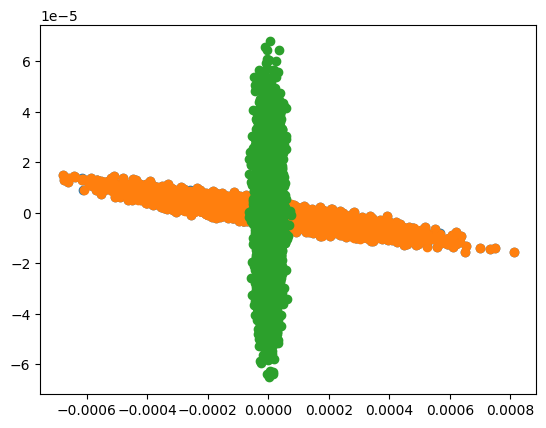

In [37]:
plt.scatter(x,px)
plt.scatter(x_s,px_s)
plt.scatter(x_n,px_n)


In [49]:
emit = calculate_emittance_new(x_n,px_n)
emit

3.438675341775696e-10

In [54]:
gamma0 = 6800/0.938

x_n,px_n=phys2norm(x,px,SVD=True)


emit_norm = normalise_emittance_new(x_n,px_n,gamma0)

In [39]:
gamma0=6800/0.938

In [55]:
emit_norm

2.492856300811477e-06

In [74]:
def load_tracker(gamma, file_with_json=str, Cpu=True):

    with open(file_with_json,'r') as fid:
        loaded_dct = json.load(fid)
        
    line = xt.Line.from_dict(loaded_dct)

    line.particle_ref = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1,
                        gamma0=gamma)
    
    part_ref = line.particle_ref 

    if Cpu == True:
        context = xo.context.Cpu
    else:
        context = xo.context.Cupy
        
    
    tracker = xt.Tracker(line=line, _context=context,)
    
    return tracker, context, part_ref


In [75]:
tracker, context, part_ref = load_set_context(file_with_json='../Examples/Example_data/bb_on_tracking_line.json',gamma=6800/0.938,Cpu=False)

Done loading line from dict.           


AttributeError: module 'xobjects.context' has no attribute 'Cupy'